
# Bayesian Optimization Tutorial
**By Stewart Jamieson & Björn Lutjens**

For this tutorial, we will attempt to find the global minima of the function $f(x)=2e^{-x} \mid x + 4sin(x)\mid - 8$ in the domain $x \in [0,10]$.
Though we have the explicit formula, it is a complicated enough function that you probably can't deduce the location of this minima by inspection.
What are some of the other strategies we could try?
 - Gradient descent (requires gradient)
 - Newton's method (requires gradient)
 - Random sampling in the interval $[0,10]$

With access to the gradient (or a numerical approximation of it), we have a couple options. These methods tend to be quite fast at finding optima when evaluting the function takes just microseconds or milliseconds, since they are similarly computationally easy and thus allow thousands of iterations per second. But what if evaluating our function was not so easy?

For example, what if instead of the above equation, $f(x)$ represented the validation loss of a large neural network after training it on an image dataset, as a function of the hyperparameters of the network (e.g. the learning rate $\alpha$)?
In that case, evaluating our function for a new value of $x$ (i.e. new neural network hyperparameters) could take hours, or days! This
could likewise be the case if $f(x)$ represented the amount of algae in one part of a lake - evaluating our function then requires deploying
a team of robots or scientists to go to the location, collect the data, and report back the results.

In these cases, methods such as those described above are highly inefficient: gradient descent usually relies on a small step size,
which means that it could take thousands or millions of function evaluations; Newton's method and other higher-order optimization methods require access to the gradient, Hessian, etc, which often cannot even be approximated easily; must we resort to random sampling in these cases?

Bayesian optimization is a tool for using Bayesian statistical analysis to select highly "informative" points to evaluate, when solving some kind of optimization problem. It is relatively computationally expensive to compute these informative points, but in cases where the function being optimized is far more expensive then this is a worthy tradeoff.

The two components of Bayesian optimization are:
1. A model for approximating the target function $f(x)$
2. An "acqusition function" $a(x)$ that tells us how informative it would be for us to sample at location $x$

An obvious way to model the target function $f(x)$ is to run a regression on our sample $(x,y)$ pairs. As Bayesian data scientists, we will employ a Gaussian process for this regression.

In [419]:
# Run this cell first to import dependencies
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.display import display
import scipy.stats as stats
from plotting import FunctionPlot
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


## Modelling $f(x)$ with a Gaussian Process

First, let's see what our function actually looks like:

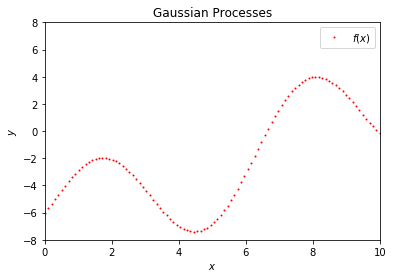

In [494]:

def f(x):
    """The function to predict."""
    return 2 * np.exp(-x) + np.abs(x + np.sin(x) * 4) - 8

fig : plt.Figure = plt.figure()
ax : plt.Axes = fig.gca()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
func_plot = FunctionPlot(ax, 'Gaussian Processes', (0, 10), (-8,8))
xs = func_plot.x
func_plot.add_function(r'$f(x)$', f, style='r.', markersize=2, locked=True)

plt.show()

We can see clearly that the global minima is located around $x=4.5$, but there are other minima at the boundaries of our domain. To model the function with a Gaussian Process, we first need to choose its hyperparameters.

As in previous classes, we will pick the Radial-Basis Function kernel (also known as the Squared-Exponential or Gaussian kernel) for our covariance, and a zero mean. For the kernel, we will pick the parameters $l=0.5, \sigma_n = 0.05$.

Note: You may recall that we previous had another kernel parameter $\sigma_f$, representing the variance of the function. Instead, we will estimate this parameter as we collect training data. This is done because the Gaussian Process implementation we are using expects the variance of our samples to always be $1$, so we treat $\sigma_f$ as a normalization quantity that we initialize to $1$.


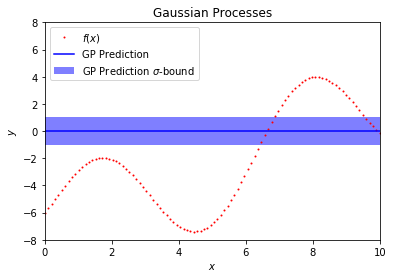

In [552]:
length_scale = 0.5
sigma_noise = 1E-1
zero_mean = True

def init_gp():
    gp = GaussianProcessRegressor(kernel=RBF(length_scale=length_scale), 
                                  alpha=sigma_noise**2,
                                  normalize_y=not zero_mean)
    return gp, 1

func_plot.reset()
gp, sigma_f = init_gp()
func_plot.add_function('GP Prediction', 
                       lambda x: scaled_predict(gp, x, sigma_f), 
                       style='b-', f_sigma_style='b')
display(fig)

Now that we have our Gaussian Process model, we just need a way to collect observations. We will assume that our observations of the true function have additive Gaussian noise, possibly with a different sigma value than our GP covariance hyperparameter.

In [633]:
true_noise = 1E-1
def y(x):
    if isinstance(x, np.ndarray):
        return f(x) + np.random.normal(0, true_noise, x.shape)
    else:
        return f(x) + np.random.normal(0, true_noise)

def train_gp(gp, train_x, train_y):
    train_x = np.array(train_x).reshape(-1,1)
    train_y = np.array(train_y).reshape(-1)
    func_plot.mark_point(train_x, train_y, 'y*', markersize=10)
    sigma_f = np.sqrt(np.sum(np.power(train_y, 2)) / train_y.shape[0])
    gp.fit(train_x, train_y / sigma_f)
    return sigma_f

def scaled_predict(gp, points, ub):
    mean, std = gp.predict(points, return_std=True)
    return mean * ub, std * ub

def plot_gp(func_plot, gp, sigma_f):
    func_plot.add_function(None,
                           lambda x: scaled_predict(gp, x, sigma_f), 
                           style='b-', f_sigma_style='b')

To test if our model is working, let's take 4 evenly spaced samples from across the domain.

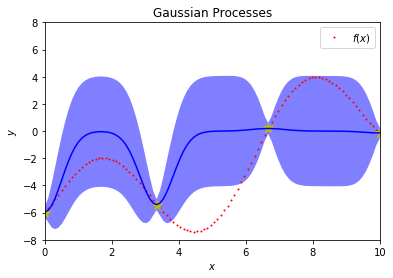

In [634]:
func_plot.reset()
test_x = np.array([0, 10.*1/3, 10.*2/3, 10.], dtype=np.float64).reshape(-1, 1)
test_y = y(test_x)

sigma_f = train_gp(gp, test_x, test_y)
plot_gp(func_plot, gp, sigma_f)
display(fig)

## The Acquisition Function

### Probability of Improvement $a_\text{PI}$

A simple and intuitive acquisition function is the probability of improvement. This is the probability that a sample at a given location will result in a value lower than our current best value by at least some value $\xi \ge 0$:

\begin{equation}
a_\text{PI}(x) = P(f(x) \le f(x_\text{best}) - \xi)
\end{equation}

Under our GP model with training data $\{x_n,y_n\}$ and hyperparameters $\theta$ this has a closed form solution:

\begin{equation}
a_\text{PI}(x) = \Phi\left(\frac{f(x_\text{best}) - \mu(x; \{x_n,y_n\}, \theta) - \xi}{\sigma(x; \{x_n,y_n\}, \theta)}\right)
\end{equation}

Let's see what it looks like initially:

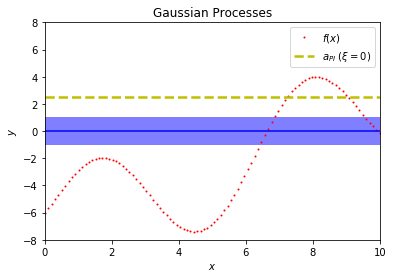

In [635]:
func_plot.reset()
gp, sigma_f = init_gp()

def PI(gp, x, sigma_f, f_best, xi=0):
    mean, std = scaled_predict(gp, x, sigma_f)
    gamma = np.divide(f_best - mean.reshape(-1) - xi, std.reshape(-1))
    return stats.norm.cdf(gamma)

def plot_PI(func_plot, gp, sigma_f, f_best, xi=0, scale=5):
    func_plot.add_function(f'$a_{{PI}}$ ($\\xi={xi}$)',
                           lambda x: PI(gp, x, sigma_f, f_best, xi) * scale, 
                           style='y--', f_sigma_style='b', 
                           linewidth=2.5)

plot_gp(func_plot, gp, sigma_f)
plot_PI(func_plot, gp, sigma_f, 0)
display(fig)


As we might expect, since there is no training data yet then our acquisition function has the same value everywhere. So, we pick the first point randomly to be $x=1$:


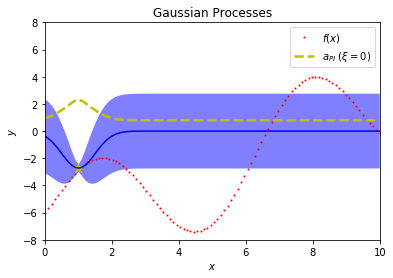

In [636]:
func_plot.reset()

train_x, train_y = [1], [y(1)]

sigma_f = train_gp(gp, train_x, train_y)
f_best = np.max(train_y)

plot_gp(func_plot, gp, sigma_f)
plot_PI(func_plot, gp, sigma_f, f_best)
display(fig)

Now we can see that our acqusition function has changed with the GP. However, the new maximum of the acqusition function is at $x=1$, which is where we just sampled! This exposes a flaw in our choice of $\xi = 0$; this value of $\xi$ indicates that we are happy with points that are equal to our previous best value, but in fact we are only interested in places where the function is lower.

A visual example of what $\alpha_\text{PI}$ represents may give us more intuition on why this happens. In the following plots, the area of the magenta shaded region represents the probability of improvement. It is computed as the following area under the normal PDF:

\begin{equation}
\mathcal{N}(y \le (f_\text{best} - \xi); \mu(x), \sigma(x))
\end{equation}

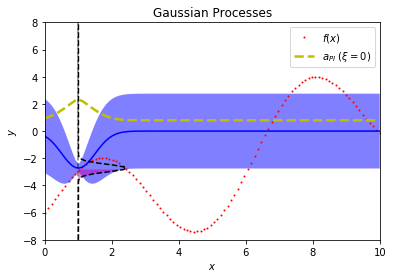

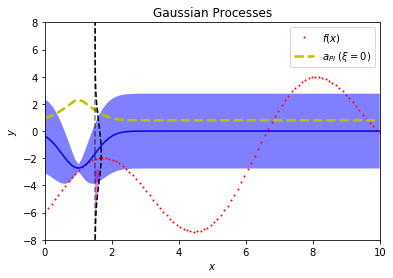

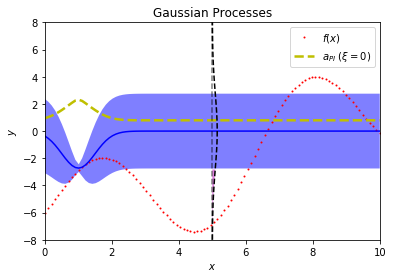

In [637]:
def show_PI_distribution(gp, sigma_f, f_best, x, xi=0):
    func_plot.reset()
    plot_PI(func_plot, gp, sigma_f, f_best, xi=xi)
    plot_gp(func_plot, gp, sigma_f)
    x = np.array(x).reshape(-1, 1)
    ys, sigma = scaled_predict(gp, x, sigma_f)
    func_plot.add_normal_pdf(x[0,0], ys[0], sigma, 'k--', 
                             highlight_below=f_best-xi, highlight_color='m')
    display(fig)
    
show_PI_distribution(gp, sigma_f, f_best, 1)
show_PI_distribution(gp, sigma_f, f_best, 1.5)
show_PI_distribution(gp, sigma_f, f_best, 5)

This visual helps us to see why a larger $\xi$ will help. In the first case, the variance is very small so most of the probability density is very close to the sample location. In the second case, the probability density more spread out. In the third case, the density is even more spread out, but since the mean is much higher than hardly any of the mass is below $f_\text{best}$. Let's try again with $\xi = 0.5$:

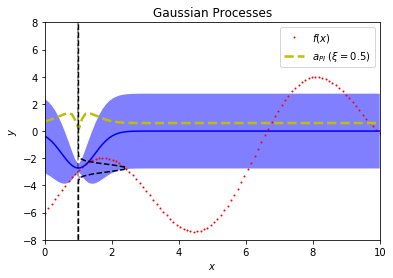

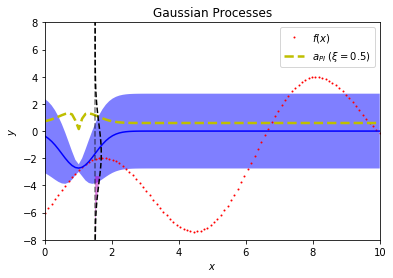

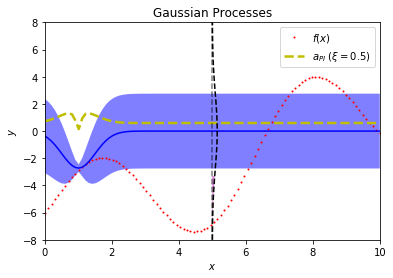

In [638]:
show_PI_distribution(gp, sigma_f, f_best, 1, xi=0.5)
show_PI_distribution(gp, sigma_f, f_best, 1.5, xi=0.5)
show_PI_distribution(gp, sigma_f, f_best, 5, xi=0.5)

This seems much more useful. Now, instead of suggesting the same point, the acquisition function suggests points slightly further away, which have a balance between a low mean and a higher variance.

Let's run a few more iterations to see how it performs. To do so, we'll define a function to suggest the next point, which is the maximum of the acquisition function in our domain.

Next point: 0.6060606060606061
Next point: 0.20202020202020202
Next point: 0.20202020202020202
Next point: 0.20202020202020202


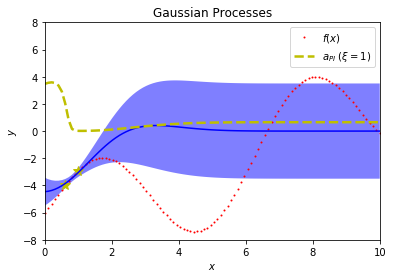

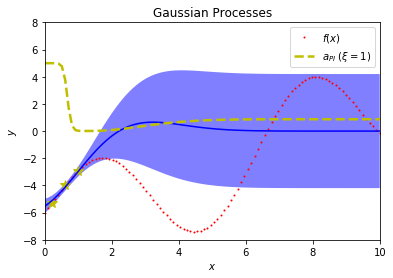

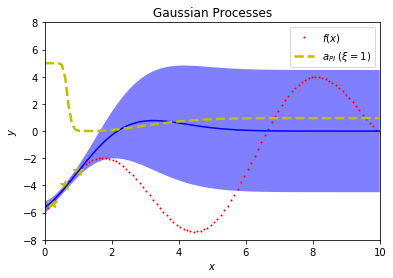

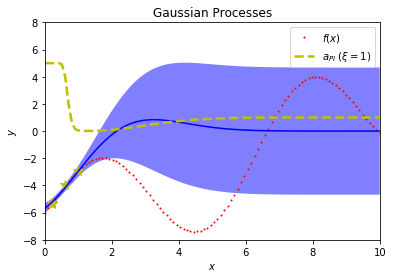

In [673]:
def suggest_next_point(gp, acquisition_function, train_x, train_y, **kwargs):
    if len(train_x) == 0:
        return 1
    sigma_f = train_gp(gp, train_x, train_y)
    acq_score = acquisition_function(gp, xs, sigma_f, np.max(train_y), **kwargs)
    return xs[np.argmax(acq_score), 0]

xi = 1
train_x, train_y = [1], [y(1)]
for i in range(4):
    next_point = suggest_next_point(gp, PI, train_x, train_y, xi=xi)
    print(f'Next point: {next_point}')
    train_x.append(next_point)
    train_y.append(y(next_point))
    
    func_plot.reset()
    sigma_f = train_gp(gp, train_x, train_y)
    f_best = np.max(train_y)
    plot_gp(func_plot, gp, sigma_f)
    plot_PI(func_plot, gp, sigma_f, f_best, xi=xi)
    display(fig)


Unfortunately it still becomes stuck in a local minimum unless we pick a very large $\xi \ge 10$.

### Expected Improvement $a_\text{EI}$


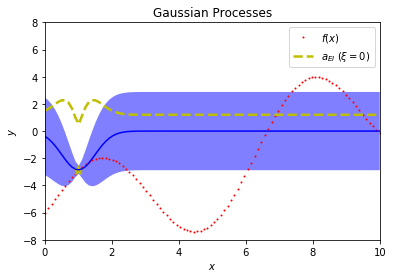

In [674]:
def EI(gp, x, sigma_f, f_best, xi=0):
    mean, std = scaled_predict(gp, x, sigma_f)
    gamma = np.divide(f_best - mean.reshape(-1) - xi, std.reshape(-1))
    prob_gamma = stats.norm.pdf(gamma, 0, 1)
    return std * (gamma * stats.norm.cdf(gamma) + prob_gamma)

def plot_EI(func_plot, gp, sigma_f, f_best, xi=0, scale=5):
    func_plot.add_function(f'$a_{{EI}}$ ($\\xi={xi}$)',
                           lambda x: EI(gp, x, sigma_f, f_best, xi) * scale, 
                           style='y--', f_sigma_style='b', 
                           linewidth=2.5)

func_plot.reset()
gp, sigma_f = init_gp()


train_x, train_y = [1], [y(1)]
sigma_f = train_gp(gp, train_x, train_y)
f_best = np.max(train_y)

plot_gp(func_plot, gp, sigma_f)
plot_EI(func_plot, gp, sigma_f, f_best)
display(fig)

Next point: 1.7171717171717171
Next point: 10.0
Next point: 6.565656565656566
Next point: 4.444444444444445


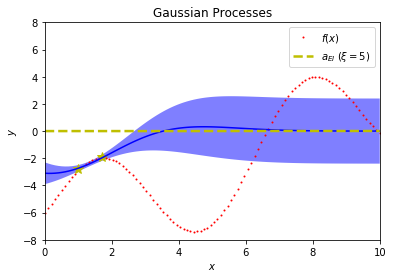

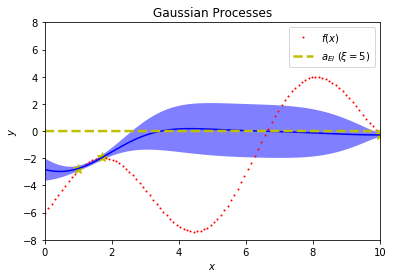

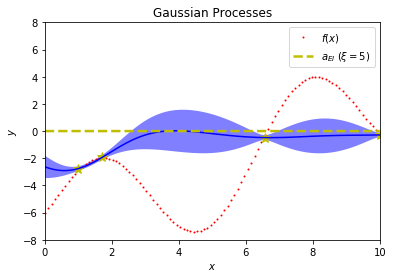

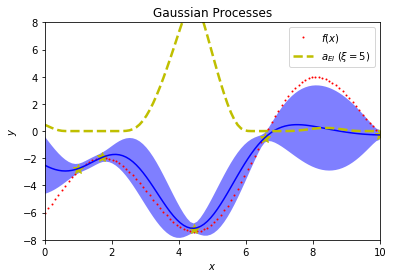

In [692]:
xi = 1
train_x, train_y = [1], [y(1)]
for i in range(4):
    next_point = suggest_next_point(gp, EI, train_x, train_y, xi=xi)
    print(f'Next point: {next_point}')
    train_x.append(next_point)
    train_y.append(y(next_point))
    
    func_plot.reset()
    sigma_f = train_gp(gp, train_x, train_y)
    f_best = np.max(train_y)
    plot_gp(func_plot, gp, sigma_f)
    plot_EI(func_plot, gp, sigma_f, f_best, xi=xi)
    display(fig)

Unfortunately even EI often gets stuck in a local minimum unless $\xi \ge 5$.

### Upper (or Lower) Confidence Bound $a_\text{LCB}$



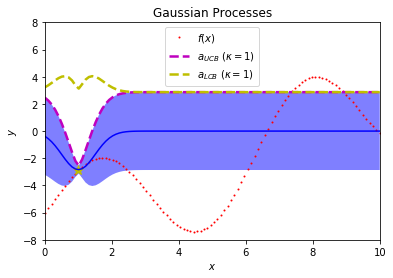

In [699]:
def UCB(gp, x, sigma_f, _, kappa=1):
    mean, std = scaled_predict(gp, x, sigma_f)
    return  kappa * std + mean

def LCB(gp, x, sigma_f, _, kappa=1):
    mean, std = scaled_predict(gp, x, sigma_f)
    return kappa * std - mean

def plot_LCB(func_plot, gp, sigma_f, f_best, kappa=0, scale=1):
    func_plot.add_function(f'$a_{{LCB}}$ ($\\kappa={kappa}$)',
                           lambda x: LCB(gp, x, sigma_f, f_best, kappa) * scale, 
                           style='y--', linewidth=2.5)

func_plot.reset()
gp, sigma_f = init_gp()


train_x, train_y = [1], [y(1)]
sigma_f = train_gp(gp, train_x, train_y)
f_best = np.max(train_y)

plot_gp(func_plot, gp, sigma_f)
func_plot.add_function(f'$a_{{UCB}}$ ($\\kappa={1}$)',
                       lambda x: UCB(gp, x, sigma_f, f_best, 1),
                       style='m--', linewidth=2.5)
plot_LCB(func_plot, gp, sigma_f, f_best, kappa=1)
display(fig)

Next point: 1.6161616161616161
Next point: 0.0
Next point: 4.747474747474747
Next point: 6.666666666666667


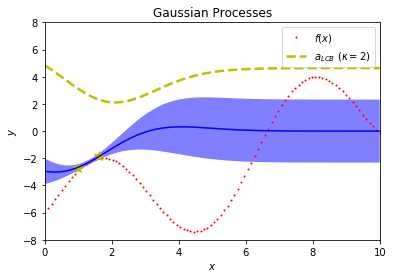

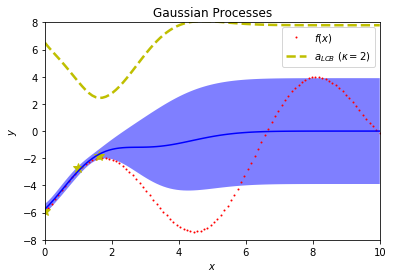

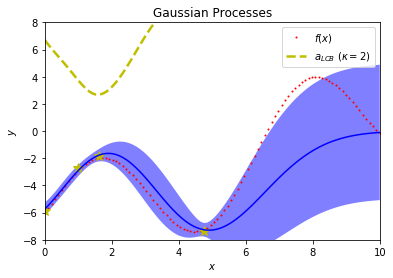

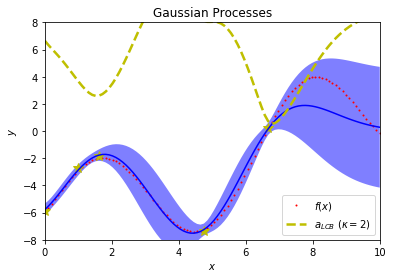

In [700]:
kappa = 2
train_x, train_y = [1], [y(1)]
for i in range(4):
    next_point = suggest_next_point(gp, LCB, train_x, train_y, kappa=kappa)
    print(f'Next point: {next_point}')
    train_x.append(next_point)
    train_y.append(y(next_point))
    
    func_plot.reset()
    sigma_f = train_gp(gp, train_x, train_y)
    f_best = np.max(train_y)
    plot_gp(func_plot, gp, sigma_f)
    plot_LCB(func_plot, gp, sigma_f, f_best, kappa=kappa)
    display(fig)
